In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [13]:
N = 75  #number of turbines
S = 3142 #total size of grid
v_inf = 4 #wind velocity without any wakes
Cp = 0.8 * 16/27
rho = 1.293
D = 100
A = np.pi * (D**2)/4
alpha = 0.1
grid = np.zeros((S,S)) #grid

In [14]:
def wake_windmill(p, q, v_t, S, x_locs, y_locs):
  #p and q is the location of that windmill
  #V_eff = np.zeros((S,S))
  V_eff = {}
  for i in range(len(x_locs)):
    x = x_locs[i]
    y = y_locs[i]
    # r = np.sqrt(D**2/(12*(1-(2/3*(D/2/(D/2 + alpha*x))**2))))
    r = alpha*(x - p) + D/2
    if x <= p:
      V_eff[str(x)+','+str(y)] = False
    else:
      if (y > (q - r)) and (y < (q + r)) :
        V_eff[str(x)+','+str(y)] = v_t * (1 - 2/3*((D/2)/((D/2) + alpha * (x - p)))**2)
      else:
        V_eff[str(x)+','+str(y)] = False

  return V_eff
  #provides dictionary containing wake velocities at points of interest

In [4]:
def superposition(turbine_locs, S):
  ''' turbine_locs = location of all turbines with order maintained
      S = size of grid'''
  x_locs = [loc[0] for loc in turbine_locs] #get the x coordinates of the windmills
  y_locs = [loc[1] for loc in turbine_locs] #get the y coordinates of the windmills
  v_effs = [] #contains calculated effective velocities for each windmill
  wakes = [] #contains wake formation for each windmill
  for i in range(len(x_locs)): 
    min_x = min(x_locs) #the leftmost windmill
    turbine = x_locs.index(min_x)
    min_y = y_locs[turbine]
    sum_sup = 1
    log = []
    for j in range(len(v_effs)): #geometric sum superposition
      wake = wakes[j][str(min_x) + ',' + str(min_y)]
      if wake:
        log.append((j, wake, v_effs[j], sum))
        #sum_sup += 1 - (wake/v_effs[j])
        sum_sup = sum_sup * (wake/v_effs[j])
    # if sum_sup > 1:
    #   # print('whoops')
    #   # print(min_x)
    #   # print(min_y)
    #   # print(log)
    #   sum_sup = 1
    v_i = v_inf*(sum_sup)
    v_effs.append(v_i) #append the calculated velocity
    #wakes.append(wake_windmill(min_x, min_y, v_i, S))
    wake_windmill_velocities = wake_windmill(min_x, min_y, v_i, S, x_locs, y_locs)
    wakes.append(wake_windmill_velocities)
    x_locs.pop(turbine)
    y_locs.pop(turbine)
  return v_effs, wakes

In [5]:
'''turbine_locs test cases'''
situation_1 = [(10,10), (20,30), (300, 250), (450, 450), (500, 1800), (1050, 1999)]
situation_2 = []
for i in range(N):
  x = random.randint(0, S)
  y = random.randint(0, S)
  situation_2.append((x, y))
situation_2 = [(ele[0] + 0.5, ele[1] + 0.3) for ele in situation_2]
situation_2

[(2140.5, 813.3),
 (2521.5, 3016.3),
 (2288.5, 1340.3),
 (2672.5, 2060.3),
 (1034.5, 3129.3),
 (2180.5, 568.3),
 (2738.5, 2488.3),
 (1929.5, 2896.3),
 (931.5, 3131.3),
 (300.5, 1747.3),
 (3135.5, 2124.3),
 (2373.5, 1342.3),
 (2459.5, 99.3),
 (1494.5, 2450.3),
 (739.5, 1684.3),
 (250.5, 2181.3),
 (1854.5, 2186.3),
 (167.5, 2220.3),
 (2676.5, 2152.3),
 (1419.5, 523.3),
 (1321.5, 2798.3),
 (789.5, 2075.3),
 (1446.5, 1813.3),
 (2339.5, 2097.3),
 (1322.5, 445.3),
 (2277.5, 461.3),
 (1780.5, 424.3),
 (2922.5, 681.3),
 (663.5, 1943.3),
 (2431.5, 2273.3)]

In [ ]:
v_effs, wakes = superposition(situation_2, S)

In [6]:
#function to generate intial windmill configuration such that distance between them is greater than some specified value and they all are in the grid
def generate_points(num_points, min_dist):
    points = []
    while len(points) < num_points:
        x = random.randint(0, S)
        y = random.randint(0, S)
        new_point = (x, y)
        if all(distance(new_point, p) > min_dist for p in points):
            points.append(new_point)
    return points

def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

# Example usage: generate N turbines with minimum distance of 2 * D between each turbine
def initiate_particles(n):
  particles = np.empty((2*N, n), dtype = int)
  for i in range(n):
    config = generate_points(N, 2*D)
    place = 0
    for j in range(len(config)):
      particles[place][i] = config[j][0]
      place += 1
      particles[place][i] = config[j][1]
      place += 1
  return particles

Functions to evaluate the windmill positions created, now implementing PSO algorithm

In [7]:
def evaluate_particles(X):
  p_objs = []
  prods = []
  for i in range(len(X[0])):
    objective = 0
    turbine_locs = [(X[j][i], X[j+1][i]) for j in range(0, len(X), 2)]
    for i, turbine in enumerate(turbine_locs):
      if (turbine[0] < 0) | (turbine[0] > S) | (turbine[1] < 0) | (turbine[1] > S):
        objective += -500
      for j, sec_turbine in enumerate(turbine_locs):
        if i != j:
          dist = np.sqrt((turbine[0] - sec_turbine[0])**2 + (turbine[1] - sec_turbine[1])**2)
          if dist < 2*D:
            objective += -500  
    veffs, wakes = superposition(turbine_locs, S)
    production = Cp * rho * A * 0.5 * sum([v**3 for v in veffs])
    objective += sum([v**3 for v in veffs])
    p_objs.append(objective)
    prods.append(production)
  return np.array(p_objs), prods

In [18]:
#initiating particles and hyperparameters
# c1 = 0.9
# c2 = 0.5
# w = 0.5
#a particle defined as a vector of length 2 * no_of_turbines: [x1,y1,x2,y2...] depicting locations of all turbines
def initialise_PSO():
  global V, X, pbest, pbest_obj, gbest, gbest_obj, production
  n_particles = 300
  np.random.seed(100)
  #X = np.random.randint(0, S, size = (2*N, n_particles)) #initiating particles and their velocities

  X = initiate_particles(n_particles)
  greedy_coords = [0, 0, 0, 1999, 0, 201, 0, 1798, 0, 402, 0, 1597, 0, 603, 0, 1396, 0, 804, 0, 1195, 45, 999, 174, 1900, 174, 99, 174, 1699, 174, 300, 174, 1498, 174, 501, 174, 1297, 174, 702, 218, 1101, 218, 898, 1999, 1999, 1999, 0, 1509, 1999, 1509, 0, 1817, 1916, 1817, 83, 1683, 1699, 1683, 300, 1683, 1498, 1683, 501, 1677, 1297, 1677, 702, 1687, 1095, 1309, 1, 1309, 1998, 1999, 853, 1642, 900, 727, 999, 673, 1800, 673, 199, 673, 1599, 673, 400, 673, 1398, 673, 601, 673, 1197, 673, 802, 653, 1999, 653, 0, 528, 1019, 474, 219, 474, 1780, 474, 420, 474, 1579, 474, 621, 474, 1378, 474, 822, 454, 1979, 454, 20, 417, 1186, 1982, 420, 1982, 1579, 1982, 621, 1962, 1778, 1962, 221, 1906, 1385, 973, 319, 973, 1680, 973, 520, 973, 1479, 973, 721, 953, 1879, 953, 120, 983, 923, 1993, 1176]
  X[:,250] = greedy_coords

  #X = np.tile(greedy_coords,(500,1)).T

  V = np.random.randint(0, S, size = (2*N, n_particles))
  pbest = X #holds the best particle iteration till current timestep
  pbest_obj, prods = evaluate_particles(X) #the best objective function value for that particle
  production = prods[pbest_obj.argmax()]
  gbest = pbest[:, pbest_obj.argmax()]
  gbest_obj = pbest_obj.max()

initialise_PSO()

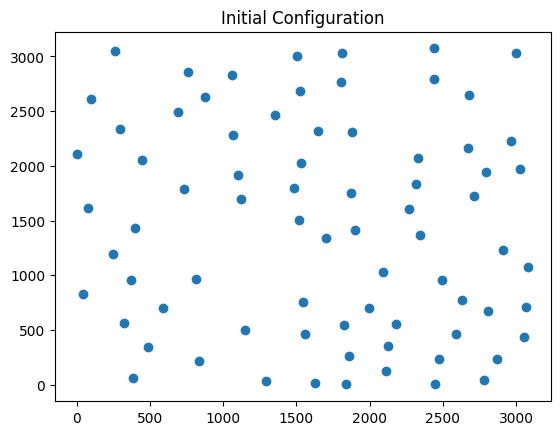

This produces 6.8183 MW of energy
[2271 1607 1070 2281 3029 1974 1523 2680  263 3052 2668 2163 2343 1371
  368  961 1122 1696   97 2609 1699 1345  489  346 1802 2764  248 1193
 2114  122 2628  779 2709 1720 2869  239 2439 2794    5 2112 3056  436
 1839    7 1877 2309 2180  558 1627   20  323  564 2494  959 1812 3031
  818  969 2591  466  386   60 2473  239 1521 1508 1858  264 1295   32
 1645 2320 2910 1231  761 2859  447 2053 1062 2830 1351 2461 1826  546
  695 2491 2090 1032 1531 2024 1993  699 2331 2070 2808  677 2449    3
  399 1430 2791 1945 1561  464 1147  505  733 1791 2997 3031  589  704
  295 2336 1501 3002 3064  715 2782   45 1545  752 1901 1411 3083 1075
 2317 1830  875 2629  835  214 2438 3072 2681 2647   74 1618 1482 1799
 2963 2224   44  830 2124  357 1104 1916 1873 1753]


In [19]:
x_coords = [gbest[i] for i in range(0, len(gbest), 2)]
y_coords = [gbest[i + 1] for i in range(0, len(gbest), 2)]
plt.scatter(x_coords, y_coords)
plt.title('Initial Configuration')
plt.show()
print('This produces ' + str(round(production/1000000, 5)) + ' MW of energy')
print(gbest)

In [10]:
def update(w, c1, c2):
    #Function to do one iteration of particle swarm optimization
    # Update params
    r1, r2 = 0.4,0.8
    #V = np.rint(w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X))
    global V, X, pbest, pbest_obj, gbest, gbest_obj, production
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X)
    X = X + V
    obj, prod = evaluate_particles(X)
    pbest[:, (pbest_obj <= obj)] = X[:, (pbest_obj <= obj)]
    pbest_obj = np.array([pbest_obj, obj]).max(axis=0)
    gbest = pbest[:, pbest_obj.argmax()]
    gbest_obj = pbest_obj.max()
    production = prod[pbest_obj.argmax()]

In [ ]:
for i in range(100):
  update(0.5, 0.9, 0.5)
  #print('Best production in ' + str(i) + ' iteration: ' + str(round(production/1000, 2)))
  if i%10 == 0:
    print('Best Objective Function in ' + str(i) + ' iteration: ' + str(round(gbest_obj, 5)))
print(gbest_obj)
print(gbest)

Best Objective Function in 0 iteration: 2845.92828
Best Objective Function in 10 iteration: 2845.92828
Best Objective Function in 20 iteration: 2845.92828
Best Objective Function in 30 iteration: 2845.96998
Best Objective Function in 40 iteration: 2845.96998
Best Objective Function in 50 iteration: 2845.96998
Best Objective Function in 60 iteration: 2845.96998
Best Objective Function in 70 iteration: 2845.96998
Best Objective Function in 80 iteration: 2845.96998
Best Objective Function in 90 iteration: 2845.96998
2845.9699773423245
[ 987  316 2543 1349  667  236 2171 1286  349  350 1339  458  629 1398
  862 2515 3020 1950 2499   26 1270 1623 2186  359 1950  458  708  437
 1873 2334 1168  718 1509 3001 1137 2913 2456 1834 1049  903 1848 2609
  608  671 1939 1987  198 2433   89 1980 1313 2153  611 1734 2819 2608
  826  753  572 1206 2803 1803 2365 1081  832 1485 1950 2989 1543 1045
 2934 3125 1636 1939 2285 2855 3133 1009 2356 2446 2838   83 2200  653
 2974  795  715 2342 2745  628 1467 

In [ ]:
gbest

array([1556,  717,  848,  788, 1407, 3097,  285,  166, 2753, 1298, 1370,
       1705,  479, 2042,  402,  385, 1239, 1554, 1878,  944, 1076, 2495,
       2788, 2697, 2963,    1, 2224, 1115,  762, 2603, 2091, 2401,   85,
        624, 1169, 1217, 1217, 2682,  509, 2366,  281, 1957, 1503, 2015,
       1881, 1652, 2457, 2884,  808, 2849, 1594,  241, 3100,  299,  326,
       1384, 3065, 2105, 2722, 3047])

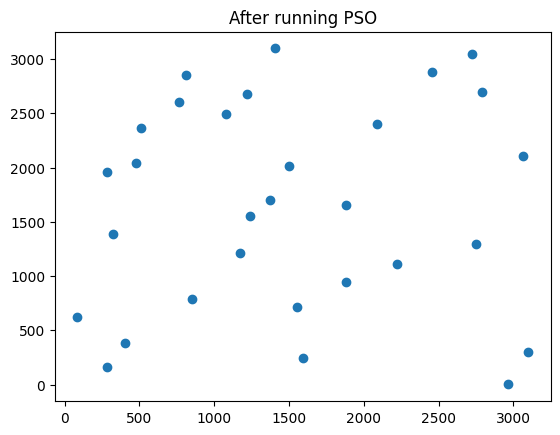

This produces 4.02503 MW of energy


In [ ]:
x_coords = [gbest[i] for i in range(0, len(gbest), 2)]
y_coords = [gbest[i + 1] for i in range(0, len(gbest), 2)]
plt.scatter(x_coords, y_coords)
plt.title('After running PSO')
plt.show()
print('This produces ' + str(round(production/1000000, 5)) + ' MW of energy')

In [ ]:
production/ (Cp * rho * A * 0.5)/(N*(v_inf**3))

0.8708892660684969

In [20]:
grid_search = {'c1': [0.3, 0.7, 1, 1.5], 'c2': [0.3, 0.7, 1, 1.5], 'w': [0.72, 1]}
best_params_obj = 0
best_params = ''
for c1 in grid_search['c1']:
  for c2 in grid_search['c2']:
    for w in grid_search['w']:
      initialise_PSO()
      for i in range(100):
        update(w, c1, c2)
        if i%20 == 0:
          print('For parameters: ' + 'w = ' + str(w) + ',' + 'c1 = ' + str(c1) + ',' + 'c2 = ' + str(c2) + ' Best Objective Function in ' + str(i) + ' iteration: ' + str(round(gbest_obj, 5)))
      if gbest_obj > best_params_obj:
        best_params = 'w = ' + str(w) + ',' + 'c1 = ' + str(c1) + ',' + 'c2 = ' + str(c2)
print(best_params)

KeyboardInterrupt: ignored

In [21]:
no_iters = 100
initialise_PSO()
for i in range(no_iters):
  w = (0.4 * ((i - no_iters)/(no_iters**2))) + 0.4
  c1 = (-3*(i/no_iters)) + 3.5
  c2 = (3*(i/no_iters)) + 0.5
  update(w, c1, c2)
  #print('Best production in ' + str(i) + ' iteration: ' + str(round(production/1000, 2)))
  if i%10 == 0:
    print('Best Objective Function in ' + str(i) + ' iteration: ' + str(round(gbest_obj, 5)))
print(gbest_obj)
print(gbest)

Best Objective Function in 0 iteration: 2860.36678
Best Objective Function in 10 iteration: 2860.36678
Best Objective Function in 20 iteration: 2861.93564
Best Objective Function in 30 iteration: 2861.93564
Best Objective Function in 40 iteration: 2861.93564
Best Objective Function in 50 iteration: 2861.93564
Best Objective Function in 60 iteration: 2861.93564
Best Objective Function in 70 iteration: 2861.93564
Best Objective Function in 80 iteration: 2861.93564
Best Objective Function in 90 iteration: 2861.93564
2861.9356385649494
[1103 2598 2628 2681 2126   40 2402  269 1110  335   55 2682  667 1851
 1446  310 1152  809  375 1879 2478 1706 2792 1259  495 2474  442 1647
 1311 2473 1537 2382  495  552 1393  596 2287 1614 2173 2813 2008 2318
 1513 1764 1967  498  153 1990 1348 1304 2784 1604 2435 2209 1077 2844
 2717 2053 1654  400  892  714 1310  156 2353 2417  879 2325  932   17
  493 2140  767 1194  319  694 1264 1905  192 1286  591  814  445 1326
  867  224 2758  897 2096  941  523 

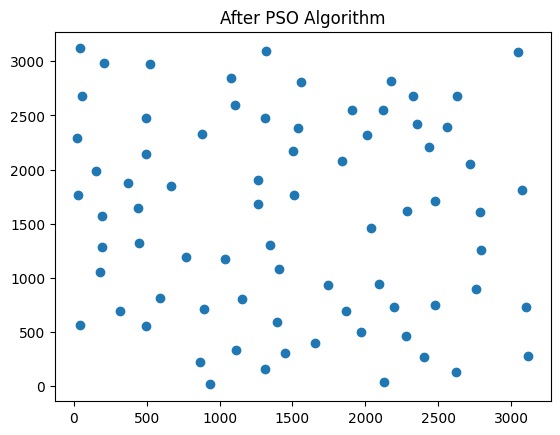

This produces 6.88522 MW of energy
[1103 2598 2628 2681 2126   40 2402  269 1110  335   55 2682  667 1851
 1446  310 1152  809  375 1879 2478 1706 2792 1259  495 2474  442 1647
 1311 2473 1537 2382  495  552 1393  596 2287 1614 2173 2813 2008 2318
 1513 1764 1967  498  153 1990 1348 1304 2784 1604 2435 2209 1077 2844
 2717 2053 1654  400  892  714 1310  156 2353 2417  879 2325  932   17
  493 2140  767 1194  319  694 1264 1905  192 1286  591  814  445 1326
  867  224 2758  897 2096  941  523 2970 2475  754 2279  466 1869  699
 3044 3082 3104  736 2197  729 1744  934   45 3117 2618  129 2039 1462
 1409 1083 1039 1177 1911 2550   43  564   26 1762 2560 2396 1557 2810
   25 2290 1261 1684  183 1055 2122 2552 1505 2168 1842 2078 1318 3095
  205 2983 3117  279  197 1568 2324 2679 3076 1809]


In [22]:
x_coords = [gbest[i] for i in range(0, len(gbest), 2)]
y_coords = [gbest[i + 1] for i in range(0, len(gbest), 2)]
plt.scatter(x_coords, y_coords)
plt.title('After PSO Algorithm')
plt.show()
print('This produces ' + str(round(production/1000000, 5)) + ' MW of energy')
print(gbest)